In [1]:
# import libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from sqlalchemy import text
from dotenv import load_dotenv

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
# connect to Redshift

load_dotenv()
dbname = os.getenv("dbname")
host = os.getenv("host")
port = os.getenv("port")
user = os.getenv("user")
password = os.getenv("password")

engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}")

In [3]:
# Use the read_sql() function to query this table and store the output as a variable

query = """
SELECT ot.*,
        case when sd.description = '?' or sd.description is null then 'Unknown' else sd.description end as description
FROM bootcamp1.online_transactions ot
LEFT JOIN bootcamp1.stock_description sd ON ot.stock_code = sd.stock_code
WHERE ot.customer_id <> '' 
AND ot.stock_code NOT IN ('BANK CHARGES', 'POSTAGE', 'D', 'M', 'CRUK')
AND ot.quantity > 0 """

online_transaction = pd.read_sql(text(query), engine)

# Remove duplicates and fix invoice_date type

online_transaction_cleaned = online_transaction.drop_duplicates(keep='first')
online_transaction_cleaned.invoice_date = pd.to_datetime(online_transaction_cleaned.invoice_date, 
                                                   format = "%Y-%m-%d")

C:\Users\Bugce\AppData\Local\Temp\ipykernel_16404\2353073207.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_transaction_cleaned.invoice_date = pd.to_datetime(online_transaction_cleaned.invoice_date,


In [4]:
online_transaction_cleaned.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,description
0,536365,84406B,8,2010-12-01 08:26:00,2.75,u1785,United Kingdom,CREAM CUPID HEARTS COAT HANGER
1,536365,21730,6,2010-12-01 08:26:00,4.25,u1785,United Kingdom,GLASS STAR FROSTED T-LIGHT HOLDER
2,536368,22913,3,2010-12-01 08:34:00,4.95,u13047,United Kingdom,RED COAT RACK PARIS FASHION
3,536367,22745,6,2010-12-01 08:34:00,2.10,u13047,United Kingdom,POPPY'S PLAYHOUSE BEDROOM
4,536367,84969,6,2010-12-01 08:34:00,4.25,u13047,United Kingdom,BOX OF 6 ASSORTED COLOUR TEASPOONS


# RFM Analysis

In [5]:
# Recency calculation

transaction_recency = online_transaction_cleaned.groupby(by="customer_id", as_index=False)["invoice_date"].max()
transaction_recency.columns = ["customer_id","last_purchase_date"]
recent_date = transaction_recency["last_purchase_date"].max()
transaction_recency["recency"] = transaction_recency["last_purchase_date"].apply(lambda x: (recent_date - x).days)
transaction_recency.head()

,customer_id,last_purchase_date,recency
0,u12346,2011-01-18 10:01:00,325
1,u12347,2011-12-07 15:52:00,1
2,u12348,2011-09-25 13:13:00,74
3,u12349,2011-11-21 09:51:00,18
4,u1235,2011-02-02 16:01:00,309


In [6]:
# Frequency calculation

transaction_frequency = online_transaction_cleaned.groupby(by="customer_id", as_index=False)["invoice_date"].nunique()
transaction_frequency.columns = ["customer_id","frequency"]
transaction_frequency.head()

,customer_id,frequency
0,u12346,1
1,u12347,7
2,u12348,4
3,u12349,1
4,u1235,1


In [7]:
# Monetary value calculation

online_transaction_cleaned["total_price"] = online_transaction_cleaned.price*online_transaction_cleaned.quantity
online_transaction_cleaned.head()

C:\Users\Bugce\AppData\Local\Temp\ipykernel_16404\1978988168.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_transaction_cleaned["total_price"] = online_transaction_cleaned.price*online_transaction_cleaned.quantity


,invoice,stock_code,quantity,invoice_date,price,customer_id,country,description,total_price
0,536365,84406B,8,2010-12-01 08:26:00,2.75,u1785,United Kingdom,CREAM CUPID HEARTS COAT HANGER,22.00
1,536365,21730,6,2010-12-01 08:26:00,4.25,u1785,United Kingdom,GLASS STAR FROSTED T-LIGHT HOLDER,25.50
2,536368,22913,3,2010-12-01 08:34:00,4.95,u13047,United Kingdom,RED COAT RACK PARIS FASHION,14.85
3,536367,22745,6,2010-12-01 08:34:00,2.10,u13047,United Kingdom,POPPY'S PLAYHOUSE BEDROOM,12.60
4,536367,84969,6,2010-12-01 08:34:00,4.25,u13047,United Kingdom,BOX OF 6 ASSORTED COLOUR TEASPOONS,25.50


In [8]:
transaction_monetary = online_transaction_cleaned.groupby(by="customer_id", as_index=False).total_price.sum()
transaction_monetary.columns = ["customer_id","monetary"]
transaction_monetary.head()

,customer_id,monetary
0,u12346,77183.60
1,u12347,4501.25
2,u12348,1797.24
3,u12349,1844.60
4,u1235,334.40


In [9]:
transaction_rf = pd.merge(transaction_recency, transaction_frequency, on="customer_id", how="inner")
transaction_rfm = pd.merge(transaction_rf, transaction_monetary, on="customer_id", how="inner").drop(columns="last_purchase_date")
transaction_rfm.head()

,customer_id,recency,frequency,monetary
0,u12346,325,1,77183.60
1,u12347,1,7,4501.25
2,u12348,74,4,1797.24
3,u12349,18,1,1844.60
4,u1235,309,1,334.40


In [10]:
# Ranking customers based on recency, frequency, monetary

transaction_rfm["r_rank"] = transaction_rfm["recency"].rank(ascending=False)
transaction_rfm["f_rank"] = transaction_rfm["frequency"].rank(ascending=True)
transaction_rfm["m_rank"] = transaction_rfm["monetary"].rank(ascending=True)

In [11]:
transaction_rfm.head()

,customer_id,recency,frequency,monetary,r_rank,f_rank,m_rank
0,u12346,325,1,77183.60,162.0,750.0,4326.0
1,u12347,1,7,4501.25,4199.5,3712.5,4012.0
2,u12348,74,4,1797.24,1651.0,3033.5,3307.0
3,u12349,18,1,1844.60,3179.0,750.0,3337.0
4,u1235,309,1,334.40,232.5,750.0,1200.0


In [12]:
# Normalizing the rank of the customer

transaction_rfm["r_rank_norm"] = (transaction_rfm["r_rank"]/transaction_rfm["r_rank"].max())*100
transaction_rfm["f_rank_norm"] = (transaction_rfm["f_rank"]/transaction_rfm["f_rank"].max())*100
transaction_rfm["m_rank_norm"] = (transaction_rfm["m_rank"]/transaction_rfm["m_rank"].max())*100

transaction_rfm.drop(columns=["r_rank","f_rank","m_rank"], inplace=True)
transaction_rfm.head()

,customer_id,recency,frequency,monetary,r_rank_norm,f_rank_norm,m_rank_norm
0,u12346,325,1,77183.60,3.777104,17.301038,99.792388
1,u12347,1,7,4501.25,97.913266,85.640138,92.549020
2,u12348,74,4,1797.24,38.493821,69.976932,76.286044
3,u12349,18,1,1844.60,74.119841,17.301038,76.978085
4,u1235,309,1,334.40,5.420844,17.301038,27.681661


In [13]:
# RFM score calculation based on RFM score=(0.15*recency score)+(0.28*frequency score)+(0.57*monetary)
# Rate on a scale of 5

transaction_rfm["rfm_score"] = (0.15*transaction_rfm["r_rank_norm"]) + \
                                (0.28*transaction_rfm["f_rank_norm"]) + \
                                (0.57*transaction_rfm["m_rank_norm"])
transaction_rfm["rfm_score"] = round(transaction_rfm["rfm_score"]*0.05,1)
transaction_rfm[["customer_id","rfm_score"]].head()

,customer_id,rfm_score
0,u12346,3.1
1,u12347,4.6
2,u12348,3.4
3,u12349,3.0
4,u1235,1.1


In [14]:
"""
Rating customer based on rfm score
top_customer: rfm_score > 4.5
high_value_customer: 4.5 > rfm_score > 4.0
medium_value_customer: 4 > rfm_score > 3
low_value_customer: 3 > rfm_score > 1.6
lost_customer: rfm_score < 1.6
"""

transaction_rfm["customer_segmentation"] = np.where(transaction_rfm["rfm_score"] > 4.5, "top_customer", \
                                            np.where(transaction_rfm["rfm_score"] > 4.0, "high_value_customer", \
                                            np.where(transaction_rfm["rfm_score"] > 3.0, "medium_value_customer", \
                                            np.where(transaction_rfm["rfm_score"] > 1.6, "low_value_customer", \
                                            "lost_customer"))))
transaction_rfm[["customer_id","rfm_score","customer_segmentation"]].head()

,customer_id,rfm_score,customer_segmentation
0,u12346,3.1,medium_value_customer
1,u12347,4.6,top_customer
2,u12348,3.4,medium_value_customer
3,u12349,3.0,low_value_customer
4,u1235,1.1,lost_customer


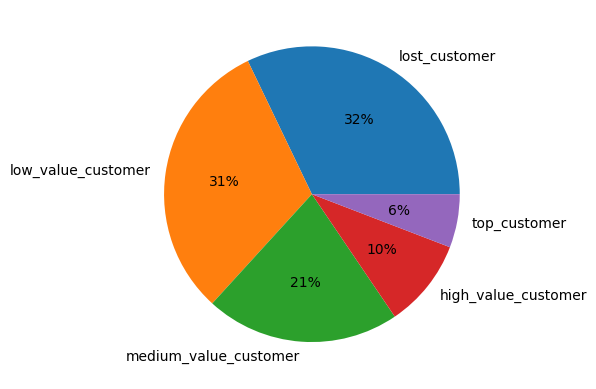

In [15]:
# Customer segment visualization

plt.pie(transaction_rfm["customer_segmentation"].value_counts(), labels=transaction_rfm["customer_segmentation"].value_counts().index[:], autopct='%.0f%%')
plt.show();

# K-Means Clustering

In [16]:
transaction_rfm.head()

,customer_id,recency,frequency,monetary,r_rank_norm,f_rank_norm,m_rank_norm,rfm_score,customer_segmentation
0,u12346,325,1,77183.60,3.777104,17.301038,99.792388,3.1,medium_value_customer
1,u12347,1,7,4501.25,97.913266,85.640138,92.549020,4.6,top_customer
2,u12348,74,4,1797.24,38.493821,69.976932,76.286044,3.4,medium_value_customer
3,u12349,18,1,1844.60,74.119841,17.301038,76.978085,3.0,low_value_customer
4,u1235,309,1,334.40,5.420844,17.301038,27.681661,1.1,lost_customer


In [17]:
transaction_rfm = transaction_rfm[["recency","frequency","monetary"]]

In [18]:
# Data normalizing

scaler = MinMaxScaler()

transaction_rfm_normalized = pd.DataFrame(scaler.fit_transform(transaction_rfm))
transaction_rfm_normalized.columns = ["n_recency", "n_frequency", "n_monetary"]
transaction_rfm_normalized.describe()

,n_recency,n_frequency,n_monetary
count,4335.000000,4335.000000,4335.000000
mean,0.245724,0.015714,0.007347
std,0.268552,0.036867,0.032136
min,0.000000,0.000000,0.000000
25%,0.045576,0.000000,0.001092
50%,0.134048,0.004854,0.002413
75%,0.380697,0.019417,0.005930
max,1.000000,1.000000,1.000000


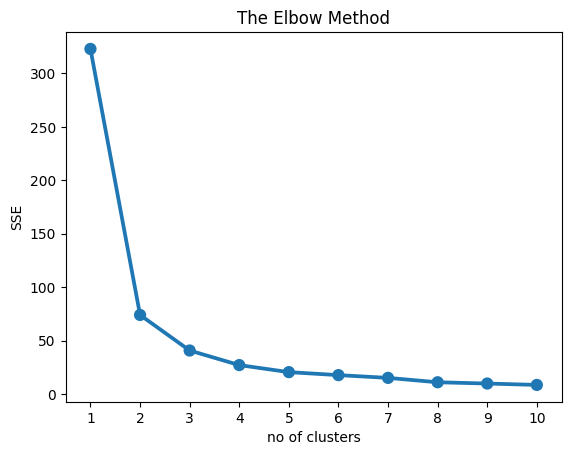

In [19]:
#Visualizing the ELBOW method to get the optimal value of K 

SSE = []
for k in range(0,10):
    kmeans = KMeans(n_clusters= k+1,  n_init='auto', random_state=1231).fit(transaction_rfm_normalized)
    SSE.append(kmeans.inertia_)
    
sns.pointplot(x=list(range(1,11)), y=SSE)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('SSE')
plt.show()

# last elbow comes at k=4

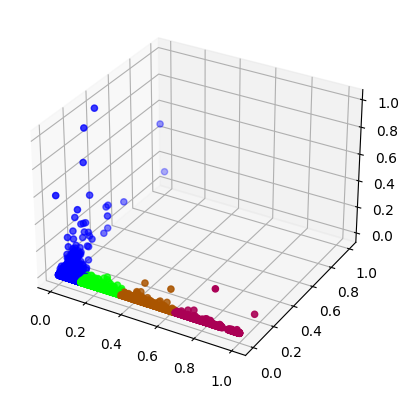

In [20]:
# Visualizing all the clusters

model = KMeans(n_clusters= 4, n_init='auto', random_state=1231).fit(transaction_rfm_normalized)
centers = model.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(transaction_rfm_normalized["n_recency"], transaction_rfm_normalized["n_frequency"], transaction_rfm_normalized["n_monetary"], 
           cmap= "brg", 
           c=model.predict(transaction_rfm_normalized))
ax.scatter(centers[:,0], centers[:,1], c="black");

For further cluster analysis, K-Means can be applied scaled R,F and M scores